In [1]:
import itertools
import collections
import re
import random

def read_input(day):
    """Read the input file for the day"""
    filename = 'input/input{}.txt'.format(day)
    with open(filename) as f:
        yield from f.read().splitlines()

# Day 1: Chronal Calibration

## Part 1


> For example, if the device displays frequency changes of +1, -2, +3, +1, then starting from a frequency of zero, the following changes would occur:

> Current frequency  0, change of +1; resulting frequency  1.
> Current frequency  1, change of -2; resulting frequency -1.
> Current frequency -1, change of +3; resulting frequency  2.
> Current frequency  2, change of +1; resulting frequency  3.
> In this example, the resulting frequency is 3.


Straightforward, just sum all the numbers in the input file.


In [2]:
sum(int(x) for x in read_input(1))

497

## Part 2

> You notice that the device repeats the same frequency change list over and over. To calibrate the device, you need to find the first frequency it reaches twice.

Now we need to loop through the input list and keep track of already seen frequencies.

In [3]:
def first_duplicate(L):
    f = 0
    seen = set()
    for fc in itertools.cycle(L):
        f += int(fc)
        if f in seen:
            return f
        else:
            seen.add(f)

first_duplicate(read_input(1))

558

# Day 2: Inventory Management System

## Part 1


> To make sure you didn't miss any, you scan the likely candidate boxes again, counting the number that have an ID containing exactly two of any letter and then separately counting those with exactly three of any letter. You can multiply those two counts together to get a rudimentary checksum and compare it to what your device predicts.

OK, so we first need to determine the frequency of characters in the inventory ID. `collections.Counter` to the rescue!

The `magic_frequency` function will, for a given string, return the resunt of the `[2x, 3x]` character test.
Afterwards, we need to sum these results. `zip()` can be used to transform the `[[2x_1, 3x_1], .. [2x_n, 3x_n]]` list to `[[2x_1, .. 2x_n], [3x_1, .. 3x_n]]`.

In [4]:
def magic_frequency(s):
    """Determine if the given string contains 2x letter or 3x letter, return list"""
    freq = collections.Counter(s)
    c = [0,0]
    if 2 in freq.values():
        c[0] = 1
    if 3 in freq.values():
        c[1] = 1
    return c

assert(magic_frequency('abcdef') == [0,0])
assert(magic_frequency('bababc') == [1,1])

checksum = list(zip(*[magic_frequency(s) for s in read_input(2)]))
sum(checksum[0]) * sum(checksum[1])

5456

## Part 2
Now we need to find two inventory IDs that differ by exactly one character. In other words, need to find two strings with edit distance of 1. First, let's sort the inputs, then compare only the neighbors

In [5]:
def edit_distance(s1, s2):
    m=len(s1)+1
    n=len(s2)+1

    tbl = {}
    for i in range(m): tbl[i,0]=i
    for j in range(n): tbl[0,j]=j
    for i in range(1, m):
        for j in range(1, n):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            tbl[i,j] = min(tbl[i, j-1]+1, tbl[i-1, j]+1, tbl[i-1, j-1]+cost)

    return tbl[i,j]

def find_inventory(L):
    L.sort()
    for idx, t in enumerate(L):
        if idx == 0:
            continue
        if edit_distance(t, L[idx-1]) == 1:
            same = ''
            for c_idx, c in enumerate(t):
                if c == L[idx-1][c_idx]:
                    same += c
            return same

assert(find_inventory(['fghij', 'fguij']) == 'fgij')
find_inventory(list(read_input(2)))

'megsdlpulxvinkatfoyzxcbvq'

# Day 3: No Matter How You Slice It

## Part 1

> Each Elf has made a claim about which area of fabric would be ideal for Santa's suit. All claims have an ID and consist of a single rectangle with edges parallel to the edges of the fabric. 

> If the Elves all proceed with their own plans, none of them will have enough fabric. How many square inches of fabric are within two or more claims?

The grid size is not given, but in this case, we can "cheat" since all the inputs are known on the website ;) A cursory look at my input data lets me know the grid is 1000x1000.

Given this constraint, it is feasible to go for a naivé solution - just create the whole grid in memory as a 2-d list, where each cell represents a point on the grid. We could even visualise the data in an image. This seems like a fun distraction, but let's focus on the problem.

First, let's parse the input lines from the format `#788 @ 16,688: 23x17`:

In [6]:
class FabricClaim(object):
    """Parser for the input data fabric claim"""
    def __init__(self, s):
        match = re.search(r'^#(\d+) @ (\d+),(\d+): (\d+)x(\d+)$', s)
        self.id, self.left, self.top, self.width, self.height = map(int, match.groups())
    
    def rectangle(self):
        """Return a tuple of rectangle coordinates"""
        return (self.left, self.top, self.left + self.width, self.top + self.height)

Now we can build the fabric grid and mark the claimed pieces. Instead of allocating a 1000x1000 list of lists immediately, I'll use a `dict` with coordinates as keys, and fabric claims as values. This may be more efficient, depening on the number of claims.

In [7]:
def build_claim_map(L):
    """Build a claim map dictionary of (x,y) coords with a set of claim IDs"""
    claimed = collections.defaultdict(set)
    for fc in map(FabricClaim, L):
        for coords in itertools.product(range(fc.left, fc.left + fc.width),
                                        range(fc.top, fc.top + fc.height)):
            claimed[coords].add(fc.id)
    return claimed

def find_overlapping_claims(claim_map):
    # sum up all the True values where a grid part has >1 claims
    return sum([len(x) > 1 for x in claim_map.values()])

assert(find_overlapping_claims(build_claim_map('''#1 @ 1,3: 4x4
#2 @ 3,1: 4x4
#3 @ 5,5: 2x2'''.split('\n'))) == 4)

find_overlapping_claims(build_claim_map(read_input(3)))

105231

## Part 2
> Amidst the chaos, you notice that exactly one claim doesn't overlap by even a single square inch of fabric with any other claim. If you can somehow draw attention to it, maybe the Elves will be able to make Santa's suit after all!

Let's find that lucky elf! We can use the `build_claim_map` function from before, with an additional enhancement for recording if claim `k` overlaps with claim `l`. We will keep track of this in another `dict` containing individual claims.

In [8]:
def build_claim_map_and_overlaps(L):
    """Build a claim map dictionary of (x,y) coords with a set of claim IDs
    
    Return the claim_map and a dict of claims with their overlaps"""
    claim_map = collections.defaultdict(set)
    overlaps = {}
    for fc in map(FabricClaim, L):
        overlaps[fc.id] = set()
        for coords in itertools.product(range(fc.left, fc.left + fc.width),
                                        range(fc.top, fc.top + fc.height)):
            # someone has already claimed this piece
            for claim in claim_map[coords]:
                overlaps[fc.id].add(claim)
                overlaps[claim].add(fc.id)
            claim_map[coords].add(fc.id)
            
    return claim_map, overlaps

We could also use this function for Part 1. I won't bother refactoring it right now. To find non-overlapping claims, we look at the overlaps dictionary and identify claims with no known overlaps.

In [9]:
def find_non_overlapping_claims(overlaps):
    non_overlaps = [claim_id for claim_id, overlap in overlaps.items() if overlap == set()]
    assert(len(non_overlaps) == 1)
    return non_overlaps[0]

assert(find_non_overlapping_claims(build_claim_map_and_overlaps('''#1 @ 1,3: 4x4
#2 @ 3,1: 4x4
#3 @ 5,5: 2x2'''.split('\n'))[1]) == 3)

find_non_overlapping_claims(build_claim_map_and_overlaps(read_input(3))[1])

164

Indeed, only one non-overlapping claim is found!

I was interested in how the claims were actually spread around. We can visualise it by drawing all claims on a 1000x1000 image! The code below requires `Pillow`.

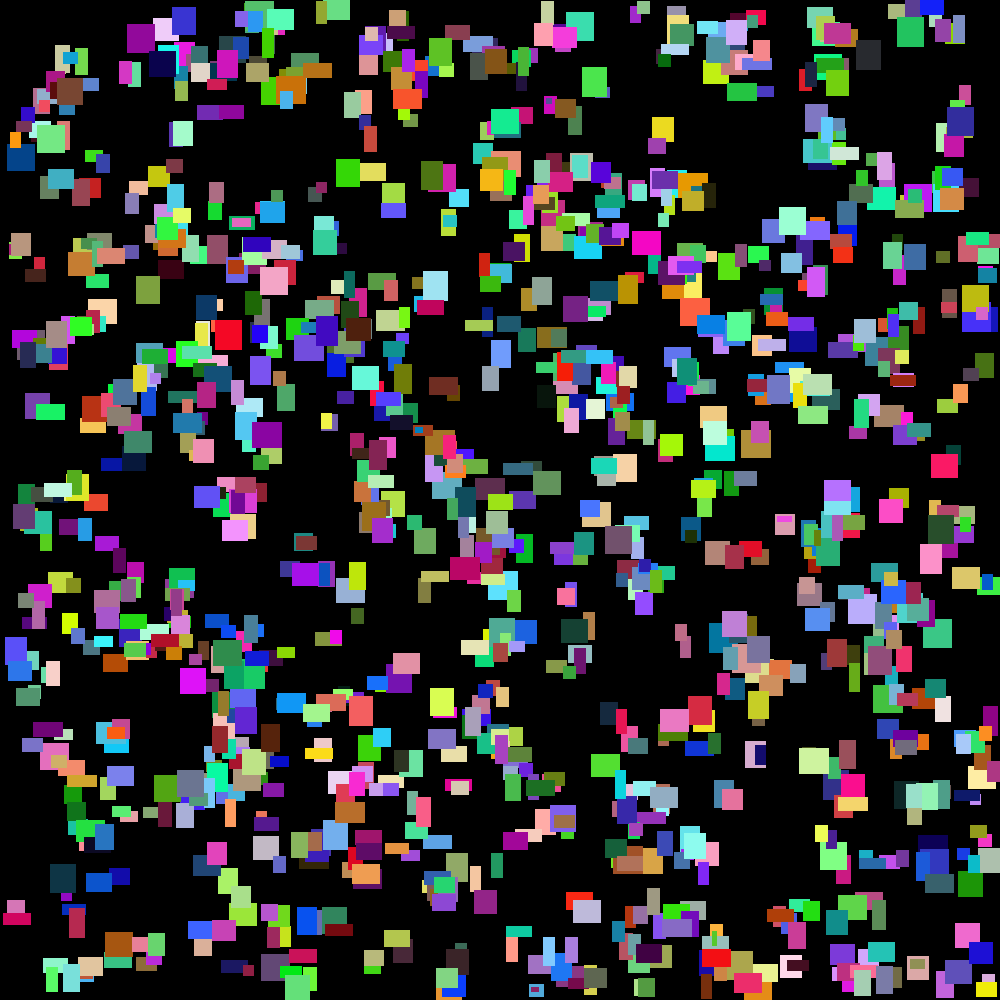

In [10]:
from PIL import Image, ImageDraw
import IPython
random.seed(42)
image = Image.new('RGB', (1000, 1000))
draw = ImageDraw.Draw(image)
for fc in (FabricClaim(s) for s in read_input(3)):
    draw.rectangle(fc.rectangle(), fill=(random.randint(1, 255), random.randint(1, 255), random.randint(1, 255)))
IPython.display.display(image)

# Day 4: Repose Record

## Part 1

> As you search the closet for anything that might help, you discover that you're not the first person to want to sneak in. Covering the walls, someone has spent an hour starting every midnight for the past few months secretly observing this guard post! They've been writing down the ID of the one guard on duty that night - the Elves seem to have decided that one guard was enough for the overnight shift - as well as when they fall asleep or wake up while at their post (your puzzle input).

> If you can figure out the guard most likely to be asleep at a specific time, you might be able to trick that guard into working tonight so you can have the best chance of sneaking in. You have two strategies for choosing the best guard/minute combination.

The input data looks like this:

```
[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
```

> The guard falling asleep or waking up is always the one whose shift most recently started. Because all asleep/awake times are during the midnight hour (00:00 - 00:59), only the minute portion (00 - 59) is relevant for those events.

This is important to know when parsing the data. A single guard is on duty, and we only care about the hour after midnight.

> Strategy 1: Find the guard that has the most minutes asleep. What minute does that guard spend asleep the most?

To identify the sleepiest guard, we need to be able to calculate total sleep time across all shifts. The input data may not be sorted, so we'll do that first. Since the time format is ISO8601-comptible (starts with the biggest unit - year, followed by progressively smaller), we can just sort the lines as strings. For every guard, we need to keep track of two things:
1. total sleep time,
2. which minutes they were sleeping.

Since all sleeping occurs in the midnight hour, we can get away with storing per-minute sleeping records for a guard in a dict, then pick the highest one. Like a lot of things in Python, we can reuse the existing `collections.Counter` class (seen in a previous day). Any hashable object can be _counted_ and the class has a convenient `most_common(n)` method for retrieving the most common objects.

In [45]:
def collect_guard_sleeps(L):
    # total time slept by Guard
    total_sleep = collections.defaultdict(int)
    # counter for keeping track of minutes slept
    sleep_minutes = collections.defaultdict(collections.Counter)
    for l in sorted(L):
        if 'Guard' in l:
            guard = re.search(r'#(\d+)', l).groups()[0]
        elif 'falls asleep' in l:
            sleep = int(re.search('(\d+)\]', l).groups()[0])
        elif 'wakes up' in l:
            wake = int(re.search('(\d+)\]', l).groups()[0])
            sleep_minutes[guard].update(range(sleep, wake))
            total_sleep[guard] += wake - sleep
    return total_sleep, sleep_minutes

def sleep_strategy_1(total_sleep, sleep_minutes):
    best_guard = max(total_sleep.items(), key=lambda x: x[1])[0]
    # Counter.most_common(1) returns the most common elements as a list of tuples: [(12, 33)]
    best_minute = sleep_minutes[best_guard].most_common(1)[0][0]
    return best_minute * int(best_guard)
    
total_sleep, sleep_minutes = collect_guard_sleeps('''[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up'''.split('\n'))

assert(sleep_strategy_1(total_sleep, sleep_minutes) == 240)

sleep_strategy_1(*collect_guard_sleeps(read_input(4)))

76357

## Part 2

> Of all guards, which guard is most frequently asleep on the same minute?

Using `Counter` was a good choice. For the second strategy, we must find the guard with the most time spent asleep within the same minute.

In [76]:
def sleep_strategy_2(sleep_minutes):
    sleepiest_minute = {guard: (sleeps.most_common(1)[0][0], sleeps.most_common(1)[0][1]) for guard, sleeps in sleep_minutes.items()}
    best_guard = max(sleepiest_minute.items(), key=lambda x: x[1][1])
    return int(best_guard[0]) * best_guard[1][0]

assert(sleep_strategy_2(sleep_minutes) == 4455)
sleep_strategy_2(collect_guard_sleeps(read_input(4))[1])

41668